Завдання:
1. Оберіть ваш варіант та завантажте необхідний файл з даними.
2. Проаналізуйте приклад використання згорткової нейронної мережі 
для класифікації зображень.
3. Змініть архітектуру нейронної мережі (кількість шарів, функції 
активації та інші параметри), а також код (за потреби) та проведіть 
експерименти по класифікації зображень відповідно до варіанту.
Занотуйте результати у звіті.
4. Проаналізуйте приклад використання підходу Transfer Learning для 
класифікації зображень CIFAR-10.
5. Замініть вашу модифіковану архітектуру мережі (пункт 3) на будьяку із доступних моделей та порівняйте результати класифікації на 
зображеннях із вашого варіанту. Чи застосування підходу Transfer 
Learning покращило результати класифікації? Обґрунтуйте результат 
та занотуйте у звіті.
6. Дайте відповіді на контрольні запитання (усно)

In [1]:
import pandas as pd
import numpy as np

# loading data

In [2]:
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

data_dir = "../data/variant-3/variant-3"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [60]:
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [61]:
from sklearn.model_selection import train_test_split

if os.path.exists(train_dir) and os.path.exists(test_dir):
  train_ds = ImageFolder(root=train_dir, transform=transform)
  test_ds = ImageFolder(root=test_dir, transform=transform)
  class_names = train_ds.classes
else:
  ds = ImageFolder(root=data_dir, transform=transform)
  class_names = ds.classes
  indices = list(range(len(ds)))
  train_indices, test_indices = train_test_split(indices, test_size=0.3, random_state=42)
  train_ds = Subset(ds, train_indices)
  test_ds = Subset(ds, test_indices)

In [62]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [63]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 2466
    Root location: ../data/variant-3/variant-3\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [64]:
test_loader.dataset

Dataset ImageFolder
    Number of datapoints: 95
    Root location: ../data/variant-3/variant-3\test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

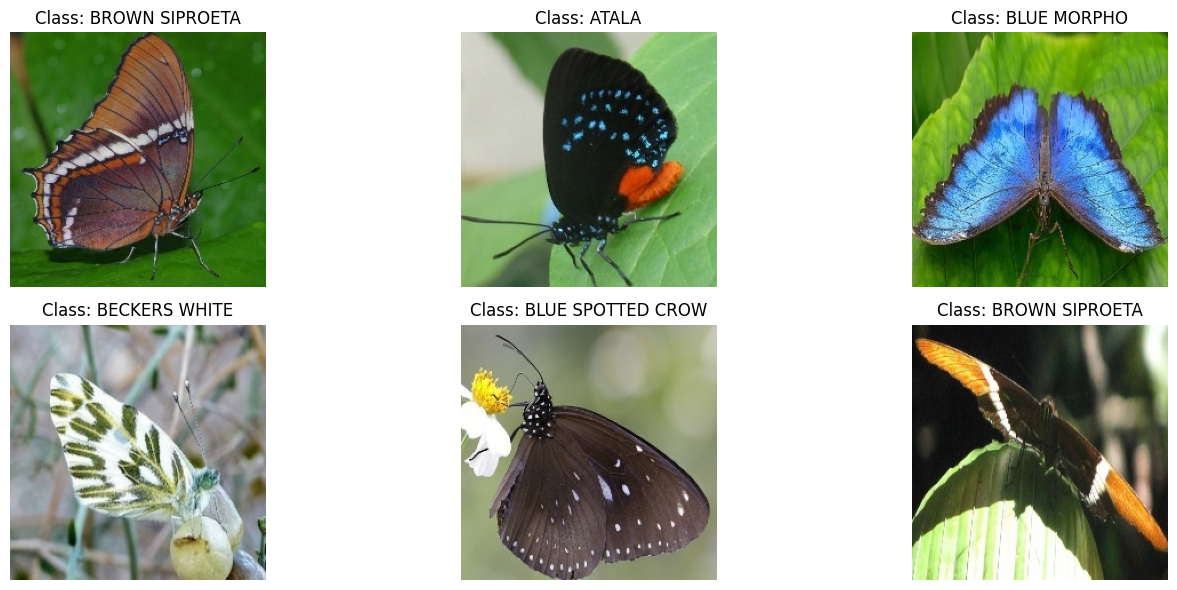

In [65]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

num_of_images = 6
plt.figure(figsize=(15, 6))
for i in range(num_of_images):
  img = images[i].numpy().transpose((1, 2, 0))
  img = np.clip(img * 0.5 + 0.5, 0, 1)
  plt.subplot(2, int(num_of_images/ 2), i + 1)
  plt.imshow(img)
  if class_names:
      plt.title(f'Class: {class_names[labels[i]]}')
  else:
      plt.title(f'Label: {labels[i].item()}')
  plt.axis('off')
plt.tight_layout()
plt.show()

# modeling

In [66]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

https://www.learnpytorch.io/03_pytorch_computer_vision/

The CNN model we're going to be using is known as TinyVGG from the CNN Explainer website.

It follows the typical structure of a convolutional neural network:

Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer

Where the contents of [Convolutional layer -> activation layer -> pooling layer] can be upscaled and repeated multiple times, depending on requirements.

In [67]:
images[0].shape

torch.Size([3, 224, 224])

This is because our nn.Conv2d() layer expects a 4-dimensional tensor as input with size (N, C, H, W) or [batch_size, color_channels, height, width].

In [68]:
import torch.nn as nn

class ButterfliesCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int, kernel_size: int = 3):
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(
        in_channels=input_shape,
        out_channels=hidden_units,
        kernel_size=kernel_size,
        stride=1, # default
        padding=1,
      ),
      nn.ReLU(),
      nn.Conv2d(
        in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=kernel_size,
        stride=1, # default
        padding=1,
      ),
      nn.ReLU(),
      nn.MaxPool2d(
        kernel_size=2,
        stride=2, # default stride value is same as kernel_size
      )
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(hidden_units, hidden_units, kernel_size=kernel_size, padding=1),
      nn.ReLU(),
      nn.Conv2d(hidden_units, hidden_units, kernel_size=kernel_size, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*56*56, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x
  
model_0 = ButterfliesCNN(
  input_shape=3,
  hidden_units=12,
  output_shape=len(class_names)
).to(device)
model_0

ButterfliesCNN(
  (block_1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=37632, out_features=12, bias=True)
    (2): ReLU()
    (3): Linear(in_features=12, out_features=19, bias=True)
  )
)

Essentially, every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space.

In other words, take a lot of numbers (raw data) and learn patterns in those numbers, patterns that are predictive whilst also being smaller in size than the original values.

From an artificial intelligence perspective, you could consider the whole goal of a neural network to compress information.

In [69]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
  params=model_0.parameters(),
  lr=0.1,
)

In [70]:
def train_model(model, train_loader, criterion, optimizer, device, epochs) -> tuple[list, list]:
  model.train()
  train_losses = []
  train_accs = []
  
  for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
      total_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct/total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
  return train_losses, train_accs  
  

In [71]:
def evaluate_model(model, test_loader, device) -> float:
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy

In [72]:
torch.manual_seed(42)

train_losses, train_accs = train_model(
  model=model_0,
  train_loader=train_loader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=3
)

Epoch 1/3, Loss: 2.9350, Accuracy: 0.0645
Epoch 2/3, Loss: 2.9131, Accuracy: 0.0706
Epoch 3/3, Loss: 2.9452, Accuracy: 0.0685


In [73]:
accuracy = evaluate_model(
  model=model_0,
  test_loader=test_loader,
  device=device,
)

Test Accuracy: 0.0526


ну може це моделька погана...

візьмем модельку з методички

In [74]:
class TeachesCNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(64 * 56 * 56, 128)
    self.fc2 = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x
model_1 = TeachesCNN(len(class_names)).to(device)
model_1

TeachesCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=19, bias=True)
  (relu): ReLU()
)

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
  model_1.parameters(), 
  lr=0.001
)

In [76]:
torch.manual_seed(42)

train_losses, train_accs = train_model(
  model=model_1,
  train_loader=train_loader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)

Epoch 1/5, Loss: 2.6043, Accuracy: 0.2490
Epoch 2/5, Loss: 1.5047, Accuracy: 0.5616
Epoch 3/5, Loss: 0.9446, Accuracy: 0.7145
Epoch 4/5, Loss: 0.5720, Accuracy: 0.8187
Epoch 5/5, Loss: 0.2752, Accuracy: 0.9189


In [77]:
accuracy = evaluate_model(
  model=model_1,
  test_loader=test_loader,
  device=device,
)

Test Accuracy: 0.6526


ага! хтось перенавчися (я😥)

але загалом, це ліпше, ніж попередня моделька.
тому треба
1. порівняти модельки (мені здається, шо проблема в класифаєрах, в першій модельці їх два шари, в нульовій - тіки один)
2. додати інші метрики, бо ота ек'юресі мені не нравиця

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class ScoreDict:
  def __init__(self):
    self.score_dict = {
      "acc" : 0,
      "prec": 0,
      "rec": 0,
      "f1": 0
    }
  def __str__(self):
    return f"\t> acc: {self.score_dict['acc']:.2f},\n\t> prec: {self.score_dict['prec']:.2f},\n\t> rec: {self.score_dict['rec']:.2f},\n\t> f1: {self.score_dict['f1']:.2f}\n\t"
  @staticmethod
  def add_dicts(x: dict, y: dict) -> dict:
    keys = set(x.keys()).intersection(set(y.keys()))
    res_dict = {}
    for key in keys:
      res_dict[key] = x.get(key) + y.get(key)
    return res_dict
  def add_scores(self, y_pred, y_true) -> dict:
    new_scores = {
      "acc": accuracy_score(y_pred, y_true),
      "prec": precision_score(y_pred, y_true, average='macro', zero_division=0),
      "rec": recall_score(y_pred, y_true, average='macro', zero_division=0),
      "f1": f1_score(y_pred, y_true, average='macro')
    }
    self.score_dict = self.add_dicts(self.score_dict, new_scores)
    return self.score_dict 
  def divide_by(self, k: float) -> dict:
    for key, value in self.score_dict.items():
      self.score_dict[key] = value / k
    return self.score_dict
    

поглянем на формат предиктів

In [79]:
images, labels = next(iter(train_loader))
labels.detach().numpy()

array([ 0, 16, 14,  2,  7, 18, 17, 17,  3, 14, 17, 15,  6,  3,  7, 13,  1,
       16,  9, 11, 16,  1,  7, 16,  7,  3, 16,  5,  3,  8, 15,  7],
      dtype=int64)

In [80]:
outputs = model_1(images.to(device))
torch.argmax(torch.sigmoid(outputs))

tensor(0, device='cuda:0')

In [81]:
[torch.argmax(x).item() for x in outputs]

[0,
 16,
 14,
 2,
 7,
 18,
 17,
 17,
 3,
 14,
 17,
 15,
 6,
 3,
 7,
 13,
 1,
 16,
 9,
 11,
 16,
 1,
 7,
 16,
 7,
 3,
 16,
 5,
 3,
 8,
 15,
 7]

In [82]:
def train_model_scores(model, train_loader, criterion, optimizer, device, epochs) -> tuple[list, list]:
  model.train()
  train_losses = []
  train_accs = []
  train_scores = [] # of ScoreDicts
  
  for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    scores = ScoreDict()
    
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      
      y_pred = [torch.argmax(x).item() for x in outputs]
      y_true = labels.cpu().detach().numpy()
      scores.add_scores(y_pred, y_true)
      
      optimizer.step()
      
      total_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
      
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct/total
    scores.divide_by(len(train_loader))
    train_scores.append(scores)
    
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    print(f"{scores}")
  return train_losses, train_accs, train_scores

додав оцей ScoreDict, надіюсь він працює

In [83]:
model_1 = TeachesCNN(len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
  model_1.parameters(), 
  lr=0.001,
)

In [84]:
torch.manual_seed(42)

train_losses, train_accs, train_scores = train_model_scores(
  model=model_1,
  train_loader=train_loader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)

Epoch 1/5, Loss: 2.4472, Accuracy: 0.2867
	> acc: 0.30,
	> prec: 0.27,
	> rec: 0.23,
	> f1: 0.22
	
Epoch 2/5, Loss: 1.1705, Accuracy: 0.6403
	> acc: 0.64,
	> prec: 0.58,
	> rec: 0.57,
	> f1: 0.54
	
Epoch 3/5, Loss: 0.6085, Accuracy: 0.8082
	> acc: 0.81,
	> prec: 0.75,
	> rec: 0.75,
	> f1: 0.73
	
Epoch 4/5, Loss: 0.2582, Accuracy: 0.9270
	> acc: 0.93,
	> prec: 0.91,
	> rec: 0.91,
	> f1: 0.90
	
Epoch 5/5, Loss: 0.0667, Accuracy: 0.9850
	> acc: 0.99,
	> prec: 0.98,
	> rec: 0.98,
	> f1: 0.98
	


In [85]:
for i in range(len(train_scores)):
  print(train_scores[i])

	> acc: 0.30,
	> prec: 0.27,
	> rec: 0.23,
	> f1: 0.22
	
	> acc: 0.64,
	> prec: 0.58,
	> rec: 0.57,
	> f1: 0.54
	
	> acc: 0.81,
	> prec: 0.75,
	> rec: 0.75,
	> f1: 0.73
	
	> acc: 0.93,
	> prec: 0.91,
	> rec: 0.91,
	> f1: 0.90
	
	> acc: 0.99,
	> prec: 0.98,
	> rec: 0.98,
	> f1: 0.98
	


воно навчається набагато довше ніж без тих метрик, напевно перекидати тензори з cpu на gpu не так і швидко. тому заберемо це в навчанні, закинем в eval, а в навчаня замість того закинем валідацію

я забув додати оці scores в ретурн😭😭😭
перед парою перезапущу

In [86]:
def train_model_validation(model, train_loader, criterion, optimizer, device, epochs) -> tuple[list, list]:
  train_losses, train_accs = [], []
  test_losses, test_accs = [], []
  
  for epoch in range(epochs):
    model.train()
    
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
      total_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct/total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # отутечки додаєм
    val_loss, val_correct, val_total = 0, 0, 0
    model.eval()
    with torch.inference_mode():
      for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        val_outputs = model(X)
        val_loss += criterion(val_outputs, y).item()
        
        _, val_predicted = torch.max(val_outputs, 1)
        val_correct += (val_predicted == y).sum().item()
        val_total += y.size(0)
      val_loss = val_loss / len(test_loader)
      val_acc = val_correct / val_total
      test_losses.append(val_loss)
      test_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f} || Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
  return train_losses, train_accs, test_losses, test_accs
  

In [87]:
model_1 = TeachesCNN(len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
  model_1.parameters(), 
  lr=0.001,
)

In [88]:
train_losses, train_accs, val_losses, val_accs = train_model_validation(
  model=model_1,
  train_loader=train_loader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)

Epoch 1/5, Loss: 2.6913, Accuracy: 0.2109 || Validation Loss: 1.7723, Accuracy: 0.4526
Epoch 2/5, Loss: 1.3837, Accuracy: 0.5762 || Validation Loss: 1.2310, Accuracy: 0.6316
Epoch 3/5, Loss: 0.7434, Accuracy: 0.7826 || Validation Loss: 1.1980, Accuracy: 0.6316
Epoch 4/5, Loss: 0.2451, Accuracy: 0.9343 || Validation Loss: 0.9878, Accuracy: 0.7474
Epoch 5/5, Loss: 0.0456, Accuracy: 0.9915 || Validation Loss: 0.9159, Accuracy: 0.7789


надто довго вчилась (note: перетренив, хвилина п'ятдесят, беру слова назад)

In [89]:
import random

def visualize_predictions(model, dataloader, device, class_names=None, num_images=5):
  model.eval()
  images, labels = next(iter(dataloader))
  with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

  plt.figure(figsize=(15, 3))
  rand_indexes = random.choices(range(len(labels)), k=num_images)
  for i in range(num_images):
    img = images[rand_indexes[i]].numpy().transpose((1, 2, 0))
    img = np.clip(img * 0.5 + 0.5, 0, 1)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    if class_names:
      true_label = class_names[labels[rand_indexes[i]]]
      pred_label = class_names[predicted[rand_indexes[i]]]
      color = 'green' if labels[rand_indexes[i]] == predicted[rand_indexes[i]] else 'red'
      plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    else:
      color = 'green' if labels[rand_indexes[i]] == predicted[rand_indexes[i]] else 'red'
      plt.title(f'True: {labels[rand_indexes[i]]}\nPred: {predicted[rand_indexes[i]]}', color=color)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

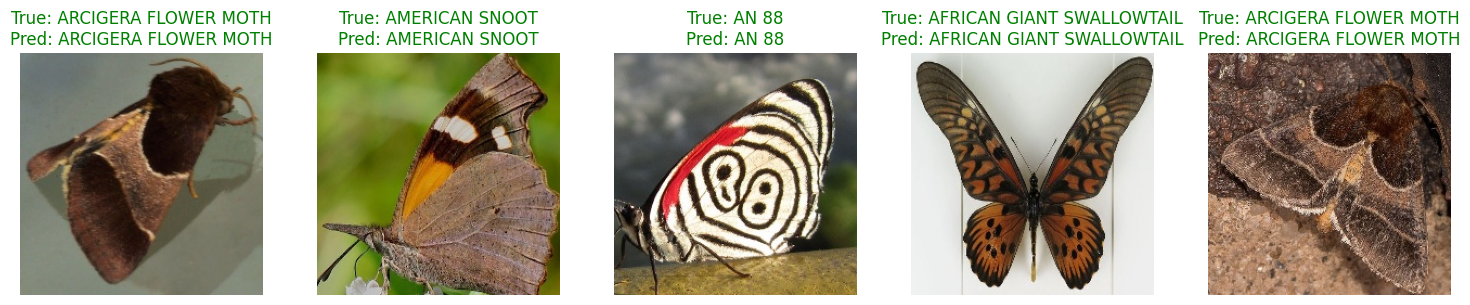

In [90]:
visualize_predictions(model_1, test_loader, device, class_names)

ващє мімо (note: перетренив, взагалі не мімо)

робим нову модельку, з багатьма класифікаційними шарами🥵

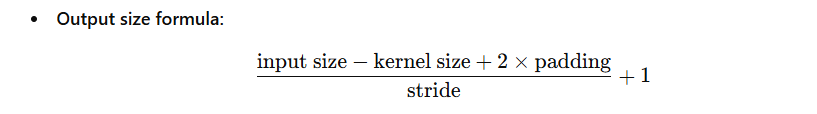

In [91]:
def calc_output_shape(conv_layer: nn.Conv2d, input_shape: int = 224) -> int:
  i, k, p, s = conv_layer.in_channels, conv_layer.kernel_size[0], conv_layer.padding[0], conv_layer.stride[0]
  return ((input_shape - k + (2 * p)) / s) + 1

In [92]:
conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
calc_output_shape(conv, input_shape=224)

112.5

In [93]:
class ButterfliesCNN_V2(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(
        in_channels=input_shape,
        out_channels=32,
        kernel_size=3,
        stride=1,
        padding=1,
      ), # -> 224
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # -> 112
    )
    self.classifier = nn.Sequential(
      nn.Linear(32 * 112 * 112, 256),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(256, output_shape),
    )
    
  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = torch.flatten(x, start_dim=1)  # Flatten to (batch_size, 32*112*112)
    x = self.classifier(x)
    return x
  
model_2 = ButterfliesCNN_V2(3, len(class_names)).to(device)
model_2

ButterfliesCNN_V2(
  (block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=401408, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=19, bias=True)
  )
)

In [94]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
  model_2.parameters(), 
  lr=0.001,
)

In [95]:
train_losses, train_accs, val_losses, val_accs = train_model_validation(
  model=model_2,
  train_loader=train_loader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)

Epoch 1/5, Loss: 2.5305, Accuracy: 0.2271 || Validation Loss: 2.5877, Accuracy: 0.2211
Epoch 2/5, Loss: 1.9990, Accuracy: 0.4006 || Validation Loss: 2.2683, Accuracy: 0.2526
Epoch 3/5, Loss: 1.7110, Accuracy: 0.5130 || Validation Loss: 2.1426, Accuracy: 0.3263
Epoch 4/5, Loss: 1.5181, Accuracy: 0.5580 || Validation Loss: 1.6236, Accuracy: 0.4947
Epoch 5/5, Loss: 1.3755, Accuracy: 0.6046 || Validation Loss: 1.7314, Accuracy: 0.3789


бідово, додамо ше один шар згортки

In [96]:
class ButterfliesCNN_V3(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(
        in_channels=input_shape,
        out_channels=32,
        kernel_size=3,
        stride=1,
        padding=1,
      ), # -> 224
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # -> 112
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(
        in_channels=32,
        out_channels=64,
        kernel_size=3,
        stride=1,
        padding=1,
      ), # -> 224
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # -> 56
    )
    self.classifier = nn.Sequential(
      nn.Linear(64 * 56 * 56, 526),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(526, 256),
      nn.ReLU(),
      nn.Linear(256, output_shape),
    )
    
  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = torch.flatten(x, start_dim=1)  # Flatten to (batch_size, 32*112*112)
    x = self.classifier(x)
    return x
  
model_3 = ButterfliesCNN_V2(3, len(class_names)).to(device)
model_3

ButterfliesCNN_V2(
  (block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=401408, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=19, bias=True)
  )
)

In [97]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
  model_3.parameters(), 
  lr=0.001,
)

In [98]:
train_losses, train_accs, val_losses, val_accs = train_model_validation(
  model=model_3,
  train_loader=train_loader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)

Epoch 1/5, Loss: 6.6279, Accuracy: 0.1655 || Validation Loss: 2.0860, Accuracy: 0.2842
Epoch 2/5, Loss: 2.0138, Accuracy: 0.3597 || Validation Loss: 1.3247, Accuracy: 0.5895
Epoch 3/5, Loss: 1.5025, Accuracy: 0.5154 || Validation Loss: 1.2960, Accuracy: 0.5263
Epoch 4/5, Loss: 1.2652, Accuracy: 0.5994 || Validation Loss: 1.1461, Accuracy: 0.6316
Epoch 5/5, Loss: 1.0947, Accuracy: 0.6290 || Validation Loss: 1.0270, Accuracy: 0.6632


In [99]:
summary(model=model_3, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ButterfliesCNN_V2 (ButterfliesCNN_V2)    [32, 3, 224, 224]    [32, 19]             --                   True
├─Sequential (block_1)                   [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 32, 224, 224]   896                  True
│    └─ReLU (1)                          [32, 32, 224, 224]   [32, 32, 224, 224]   --                   --
│    └─MaxPool2d (2)                     [32, 32, 224, 224]   [32, 32, 112, 112]   --                   --
├─Sequential (classifier)                [32, 401408]         [32, 19]             --                   True
│    └─Linear (0)                        [32, 401408]         [32, 256]            102,760,704          True
│    └─ReLU (1)                          [32, 256]            [32, 256]            --                   --
│    └─Dropout (2)  

поки моделька трениться - вчимось-читаєм (note: навчилась, ну такеее)

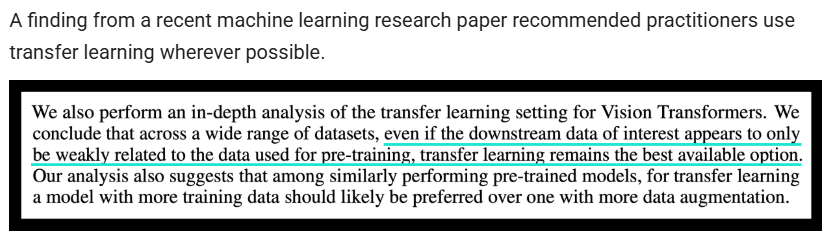

https://www.learnpytorch.io/06_pytorch_transfer_learning/

# transfer learning

як я по трансферу по ерзмусу не поїхав, то хоть моделька покатається🐱‍🐉

In [100]:
import torch
import torchvision
from torchvision import transforms
from torchinfo import summary

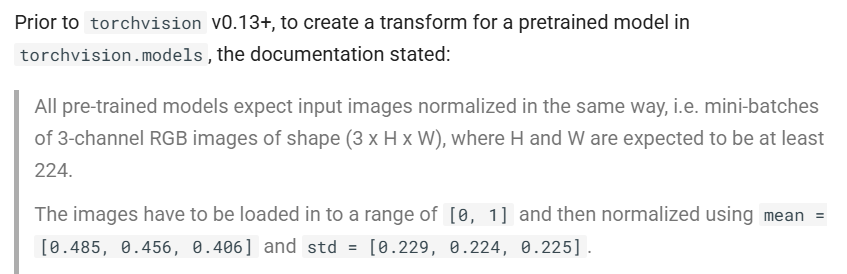

In [101]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
  transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
  transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
  transforms.Normalize(
    mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
    std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [102]:
# create dataloaders
import os

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = ImageFolder(train_dir, transform=transform)
  test_data = ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [103]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
  train_dir=train_dir,
  test_dir=test_dir,
  transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
  batch_size=32) # set mini-batch size to 32
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1f93b8f0e50>,
 ['ADONIS',
  'AFRICAN GIANT SWALLOWTAIL',
  'AMERICAN SNOOT',
  'AN 88',
  'APPOLLO',
  'ARCIGERA FLOWER MOTH',
  'ATALA',
  'ATLAS MOTH',
  'BANDED ORANGE HELICONIAN',
  'BANDED PEACOCK',
  'BANDED TIGER MOTH',
  'BECKERS WHITE',
  'BIRD CHERRY ERMINE MOTH',
  'BLACK HAIRSTREAK',
  'BLUE MORPHO',
  'BLUE SPOTTED CROW',
  'BROOKES BIRDWING',
  'BROWN ARGUS',
  'BROWN SIPROETA'])

але це якшо вручну, а можна підгрузити з модельки

# EfficientNet

EfficientNet (2019) використовує метод масштабування compound 
scaling, який пропорційно збільшує глибину, ширину та роздільну здатність 
мережі. Це дозволило створити сімейство моделей (B0-B7) з оптимальним 
балансом між точністю та ефективністю

In [104]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [105]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

а тепер туторіал

The pretrained model we're going to be using is torchvision.models.efficientnet_b0().

The architecture is from the paper EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks.

In [106]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights for ImageNet
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model # uncomment to output (it's very long) а таки вері лонґ

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

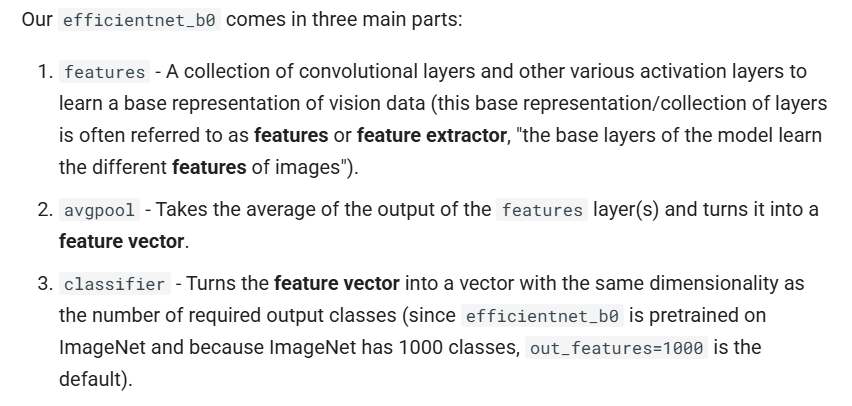

In [107]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

We can freeze all of the layers/parameters in the features section by setting the attribute requires_grad=False.

For parameters with requires_grad=False, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In [108]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
  param.requires_grad = False

In [109]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
  torch.nn.Dropout(p=0.2, inplace=True), 
  torch.nn.Linear(
    in_features=1280, 
    out_features=output_shape, # same number of output units as our number of classes
    bias=True)
).to(device)

In [110]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 19]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# а тепер вчить

In [111]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [112]:
model._get_name()

'EfficientNet'

але давайте перше то якось запм'ятовувати будем чи шо

In [113]:
competition_map = {}

In [114]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_losses, train_accs, val_losses, val_accs = train_model_validation(
  model=model,
  train_loader=train_dataloader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)
competition_map[model._get_name()] = [train_losses, train_accs, val_losses, val_accs]

Epoch 1/5, Loss: 1.5252, Accuracy: 0.7393 || Validation Loss: 0.9944, Accuracy: 0.8842
Epoch 2/5, Loss: 0.5085, Accuracy: 0.9469 || Validation Loss: 0.7229, Accuracy: 0.9263
Epoch 3/5, Loss: 0.3266, Accuracy: 0.9611 || Validation Loss: 0.6388, Accuracy: 0.8632
Epoch 4/5, Loss: 0.2555, Accuracy: 0.9667 || Validation Loss: 0.6809, Accuracy: 0.8526
Epoch 5/5, Loss: 0.2030, Accuracy: 0.9753 || Validation Loss: 0.3868, Accuracy: 0.9368


In [115]:
cm = pd.DataFrame(competition_map[model._get_name()])
cm.T.iloc[-1] # дані з останньої 5ї епохи

0    0.202999
1    0.975264
2    0.386823
3    0.936842
Name: 4, dtype: float64

In [116]:
accuracy = evaluate_model(
  model=model,
  test_loader=test_dataloader,
  device=device,
)

Test Accuracy: 0.9684


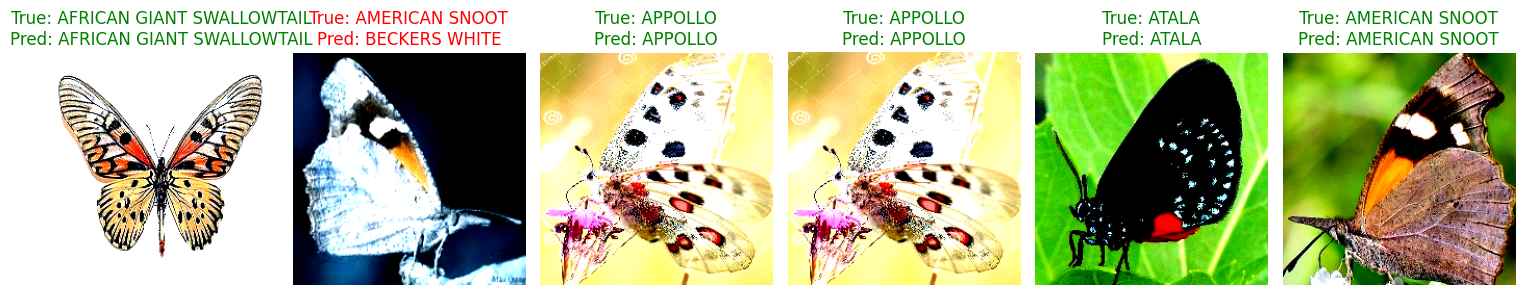

In [117]:
visualize_predictions(model, test_dataloader, device, class_names, num_images=6)

# почнемо зберігати модельки

In [118]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

In [119]:
# Create model save path
MODEL_NAME = "cv_efficient-net_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [120]:
# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model, # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\cv_efficient-net_1.pth


In [121]:
model_restored = torch.load(MODEL_SAVE_PATH)
summary(model_restored,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

C:\Users\Omen\AppData\Local\Temp\ipykernel_16436\3908664170.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_restored = torch.load(MODEL_SAVE_PATH)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 19]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

хух, та сама моделька

тепер можна попробувати інші, а потім... а потім я хочу застекати їх

є ше отакі модельки

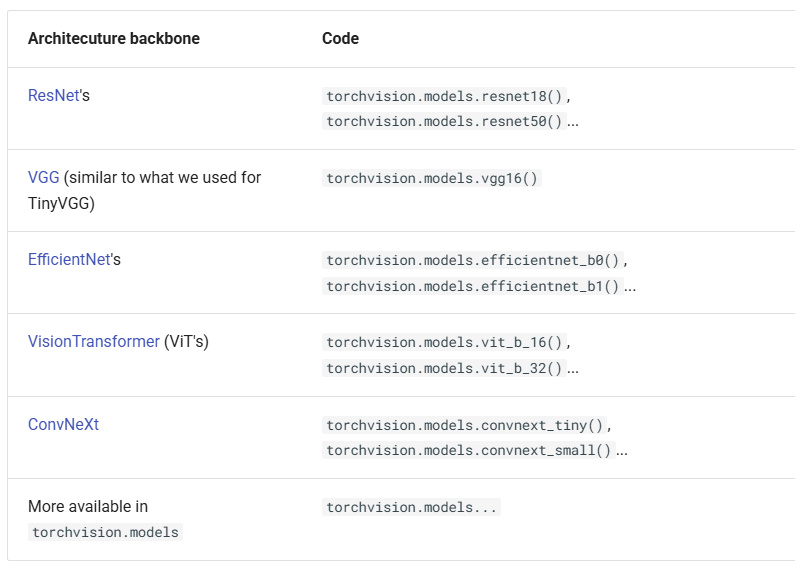

In [122]:
weights = torchvision.models.ResNet18_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ResNet18_Weights.IMAGENET1K_V1

# ResNet

ResNet (2015) представила революційну концепцію залишкових з'єднань 
(skip connections), які дозволяють ефективно навчати дуже глибокі мережі, 
вирішуючи проблему затухаючих градієнтів. ResNet має версії з різною 
глибиною (ResNet18, ResNet34, ResNet50, ResNet101), де більша глибина 
зазвичай дає кращу точність.

In [123]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [124]:
model_res_net = torchvision.models.resnet18(weights=weights).to(device)

In [125]:
summary(model_res_net,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

а отут нема окремого блоку на features тому зробимо як в прикладі методички

In [126]:
for param in model.parameters():
  param.requires_grad = False

In [127]:
# Unfreeze final layer
for param in model_res_net.fc.parameters():  # or model.classifier.parameters()
  param.requires_grad = True

In [128]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_res_net.fc = nn.Linear(
  in_features=512,
  out_features=len(class_names)
).to(device)

In [129]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_res_net.parameters(), lr=0.001)

In [130]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_losses, train_accs, val_losses, val_accs = train_model_validation(
  model=model_res_net,
  train_loader=train_dataloader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)
competition_map[model_res_net._get_name()] = [train_losses, train_accs, val_losses, val_accs]

Epoch 1/5, Loss: 0.5808, Accuracy: 0.8418 || Validation Loss: 0.5364, Accuracy: 0.8632
Epoch 2/5, Loss: 0.2468, Accuracy: 0.9347 || Validation Loss: 2.2716, Accuracy: 0.5895
Epoch 3/5, Loss: 0.1862, Accuracy: 0.9497 || Validation Loss: 1.2293, Accuracy: 0.7368
Epoch 4/5, Loss: 0.1863, Accuracy: 0.9534 || Validation Loss: 0.1639, Accuracy: 0.9263
Epoch 5/5, Loss: 0.1495, Accuracy: 0.9639 || Validation Loss: 0.6302, Accuracy: 0.8632


In [131]:
MODEL_NAME = "cv_res-net-18_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [132]:
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model, # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\cv_res-net-18_1.pth


# DenseNet (2017)

 розвинула ідею skip connections, створюючи щільні 
з'єднання між шарами - кожен шар отримує на вхід конкатенацію виходів всіх 
попередніх шарів. Це забезпечує кращий потік градієнтів та перевикористання 
ознак

In [133]:
weights = torchvision.models.DenseNet121_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet

auto_transforms = weights.transforms()

model_dense_net = torchvision.models.densenet121(weights=weights).to(device)

In [134]:
summary(model_dense_net,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1024, 7, 7]     --                   True
│    └─Conv2d (conv0)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 56]    

In [135]:
for param in model_dense_net.features.parameters():
  param.requires_grad = False
  
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate the classifier layer and seed it to the target device
model_dense_net.classifier = torch.nn.Sequential(
  torch.nn.Dropout(p=0.2, inplace=True), 
  torch.nn.Linear(
    in_features=1024, 
    out_features=len(class_names), # same number of output units as our number of classes
    bias=True)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dense_net.parameters(), lr=0.001)

train_losses, train_accs, val_losses, val_accs = train_model_validation(
  model=model_dense_net,
  train_loader=train_dataloader,
  criterion=loss_fn,
  optimizer=optimizer,
  device=device,
  epochs=5
)
competition_map[model_dense_net._get_name()] = [train_losses, train_accs, val_losses, val_accs]

Epoch 1/5, Loss: 1.6735, Accuracy: 0.6513 || Validation Loss: 0.7142, Accuracy: 0.9263
Epoch 2/5, Loss: 0.5552, Accuracy: 0.9331 || Validation Loss: 0.3492, Accuracy: 0.9684
Epoch 3/5, Loss: 0.3517, Accuracy: 0.9550 || Validation Loss: 0.2328, Accuracy: 0.9789
Epoch 4/5, Loss: 0.2490, Accuracy: 0.9688 || Validation Loss: 0.1919, Accuracy: 0.9789
Epoch 5/5, Loss: 0.2006, Accuracy: 0.9761 || Validation Loss: 0.1512, Accuracy: 0.9789
